Use Random Forest with SSURGO regressors to create CONUS maps of soil calcite and kaolinite contents

predictors: 'Latitude','Longitude','elevation','hzn_mid' + ssurgo_file_list

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import os
import rasterio as rio
import itertools as it
from pyproj import Transformer, CRS
import xarray as xr
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import from_bounds
from scipy.interpolate import griddata
from scipy.stats import pearsonr
import xarray as xr

path_data = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'USGS_mineralmap')
path_out = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results')

elm_nodes = np.array([0.0071, 0.0279, 0.0623, 0.1189, 0.2122, 0.3661, 0.6198, 1.0380, 1.7276, 
                      2.8646])

# if true, force recreation of reprojected predictor maps at 0.5 degrees
# if false, only generate the files that do not exist. 
recreate_reproj_files = True

# Pick the variable to fit the Random Forest model on and create map for
varname = 'Calcite' # 'Kaolinit' # 'Calcite'

1. Read and intersect the valid point scale data

In [2]:
alldata = []
for i,layer in enumerate(['A','C'], 3):
    data = pd.read_excel(os.path.join(path_data, f'Appendix_{i}a_{layer}horizon_18Sept2013.xls'), 
                        skiprows = 12).iloc[1:, :]
    data = data.loc[:, ['SiteID', 'Latitude', 'Longitude', 'LandCover1', 'LandCover2',
                        f'{layer}_Depth', f'{layer}_Kaolinit', f'{layer}_Calcite']
                   ].dropna(subset = [f'{layer}_Kaolinit', f'{layer}_Calcite'], how = 'all')
    data['SiteID'] = data['SiteID'].astype(int)
    data = data.rename({f'{layer}_Depth': 'Depth',
                        f'{layer}_Kaolinit': 'Kaolinit', 
                        f'{layer}_Calcite': 'Calcite'}, axis = 1)
    # N.D. indicates an undetected mineral phase.
    data.replace('N.D.', 0., inplace=True)

    # skip the depths that starts with '<', '>', 'N.S', 'Not recorded'
    data = data.loc[[not (d.startswith('<') or d.startswith('>') or d == 'N.S.' \
                     or d == 'Not recorded' or d == 'not recorded') for d in data['Depth']], :]
    
    # N.S. indicates not a sample, in Kaolinit & Calcite columns
    data.replace('N.S.', np.nan, inplace = True)
    data['Kaolinit'] = data['Kaolinit'].astype(float)
    data['Calcite'] = data['Calcite'].astype(float)

    # separate the depth range, convert from cm to m
    data['hzn_top'] = [float(d.split('-')[0])/100 for d in data['Depth']]
    data['hzn_bot'] = [float(d.split('-')[1])/100 for d in data['Depth']]
    data = data.drop('Depth', axis = 1)

    alldata.append(data)
alldata = pd.concat(alldata, axis = 0).sort_values(by = 'hzn_top')
# drop NA; fortunately, they are common between Kaolinit and Calcite
alldata = alldata.dropna(axis = 0, how = 'all', subset = ['Kaolinit', 'Calcite'])

## Append elevation data
#hr = xr.open_dataset(os.path.join(os.environ['E3SM_ROOT'], 'inputdata', 'lnd', 'clm2', 
#                                  'surfdata_map','surfdata_conus_erw_on_simyr1850_c211019.nc'))
#elevation_list = []
#for siteID, row in alldata.iterrows():
#    x, y = np.unravel_index(np.argmin( \
#        np.power(hr['LONGXY'].values - 360 - row['Longitude'],2) + \
#        np.power(hr['LATIXY'].values - row['Latitude'],2) ), hr['LONGXY'].shape)
#    elevation_list.append(hr['TOPO'].values[x, y])
#alldata['elevation'] = elevation_list
#hr.close()

alldata['hzn_mid'] = (alldata['hzn_bot'] + alldata['hzn_top']) / 2

alldata

,SiteID,Latitude,Longitude,LandCover1,LandCover2,Kaolinit,Calcite,hzn_top,hzn_bot,hzn_mid
4822,10043,41.6240,-110.9207,Shrubland,Shrubland,1.9,5.5,0.00,0.03,0.015
3196,7164,39.9656,-83.4528,Planted/Cultivated,Row Crops,3.0,0.0,0.00,0.25,0.125
3195,6908,39.7261,-83.2184,Planted/Cultivated,Small Grains,1.5,0.0,0.00,0.23,0.115
3194,6736,41.4631,-83.2989,Planted/Cultivated,Row Crops,0.0,0.0,0.00,0.24,0.120
3193,6524,40.0718,-81.2417,Developed,Low Intensity Residential,6.9,0.0,0.00,0.10,0.050
...,...,...,...,...,...,...,...,...,...,...
1055,12776,40.7173,-92.9936,Planted/Cultivated,Row Crops,0.0,0.0,1.38,1.65,1.515
1031,9448,40.6756,-91.3687,Planted/Cultivated,Row Crops,0.0,0.0,1.39,1.67,1.530
998,4888,41.2588,-95.2893,Planted/Cultivated,Row Crops,2.2,0.0,1.40,1.57,1.485
4278,3643,40.6473,-112.3082,Developed,Low Intensity Residential,0.0,14.9,1.40,1.57,1.485


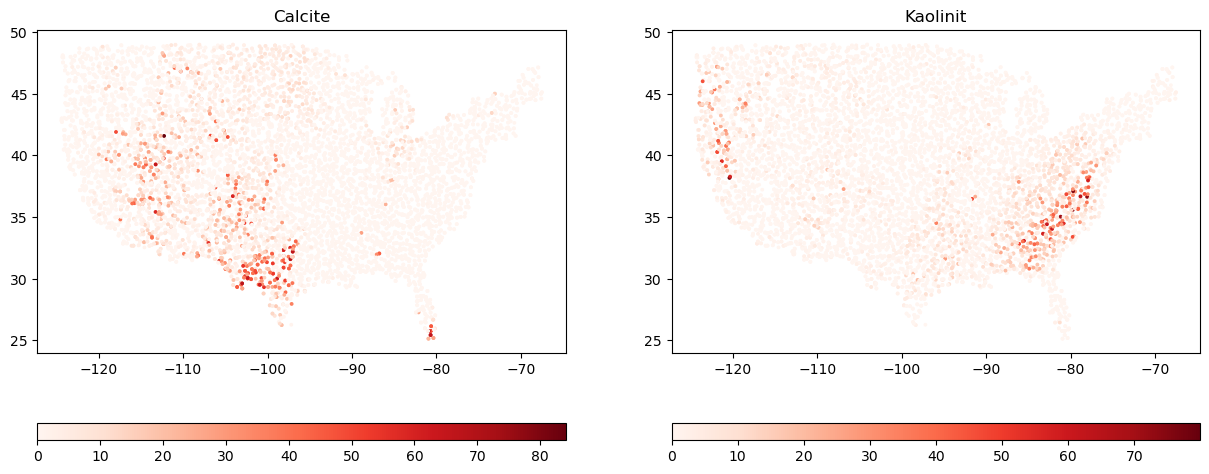

In [3]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
ax = axes.flat[0]
cf = ax.scatter(alldata['Longitude'], alldata['Latitude'], c = alldata['Calcite'], s = 3, 
                cmap = 'Reds')
ax.set_title('Calcite')
plt.colorbar(cf, ax = ax, orientation = 'horizontal', aspect = 30)
ax = axes.flat[1]
cf = ax.scatter(alldata['Longitude'], alldata['Latitude'], c = alldata['Kaolinit'], s = 3, 
                cmap = 'Reds')
ax.set_title('Kaolinit')
plt.colorbar(cf, ax = ax, orientation = 'horizontal', aspect = 30)

2. Build the calcite/kaolinite prediction model

In [4]:
# Read the predictors from SSURGO
def read_raster(src_file, lat_list, lon_list, band):
    h = rio.open(src_file)
    array = h.read(band, masked = True)
    array = np.where(array.mask, np.nan, array)
    if h.crs != CRS.from_epsg(4326):
        transformer = Transformer.from_crs(CRS.from_epsg(4326), h.crs, always_xy=True)
    # List to store the extracted values
    extracted_values = []
    for lat, lon in zip(lat_list, lon_list):
        if h.crs != CRS.from_epsg(4326):
            # Transform lat/lon to x/y coordinates in the GeoTIFF's CRS
            x, y = transformer.transform(lon, lat)
        else:
            x, y = lon, lat
        # Get the pixel coordinates
        row, col = h.index(x, y)
        # Check if the point is within the raster bounds
        if 0 <= row < h.height and 0 <= col < h.width:
            # Extract values for all bands
            values = array[row, col]
            extracted_values.append(values)
        else:
            extracted_values.append(np.nan)  # Out of bounds
    h.close()
    return np.array(extracted_values)

lat_list, lon_list = alldata['Latitude'], alldata['Longitude']

# verified that cec and soil organic matter are not useful! 
# mean_ksat is marginal: only decreased by 0.001
# rf_025 surprisingly useful
# ph_025 also not useful
ssurgo_file_list = ['caco3_kg_sq_m', 'db', 'soil_depth', 'rf_025',
                    'ph', 'ph_05', 'ph_025', 'ph_3060',
                    'sand', 'sand_05', 'sand_025', 'sand_3060',
                    'clay', 'clay_05', 'clay_025', 'clay_3060']
for file in ssurgo_file_list:
    src_file = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'SSURGO', f'{file}.tif')
    alldata.loc[:, file] = read_raster(src_file, lat_list, lon_list, 1)

alldata.loc[:, 'caco3_kg_sq_m'] = np.log(alldata['caco3_kg_sq_m'] + 1)

src_file = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'USGS_3DEP_800m_EPSG5070.tif')
alldata.loc[:, 'elevation'] = read_raster(src_file, lat_list, lon_list, 1)

src_file = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                        'DAYMET_V4_Climatology_1980_2010.tif')
alldata.loc[:, 'prcp'] = read_raster(src_file, lat_list, lon_list, 1)
alldata.loc[:, 'tmax'] = read_raster(src_file, lat_list, lon_list, 2)
alldata.loc[:, 'tmin'] = read_raster(src_file, lat_list, lon_list, 3)

alldata = alldata.dropna(axis = 0, how = 'any')

/ccsopen/home/ywo/.conda/envs/myCondaEnv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Text(0, 0.5, 'Observed Calcite (%)')

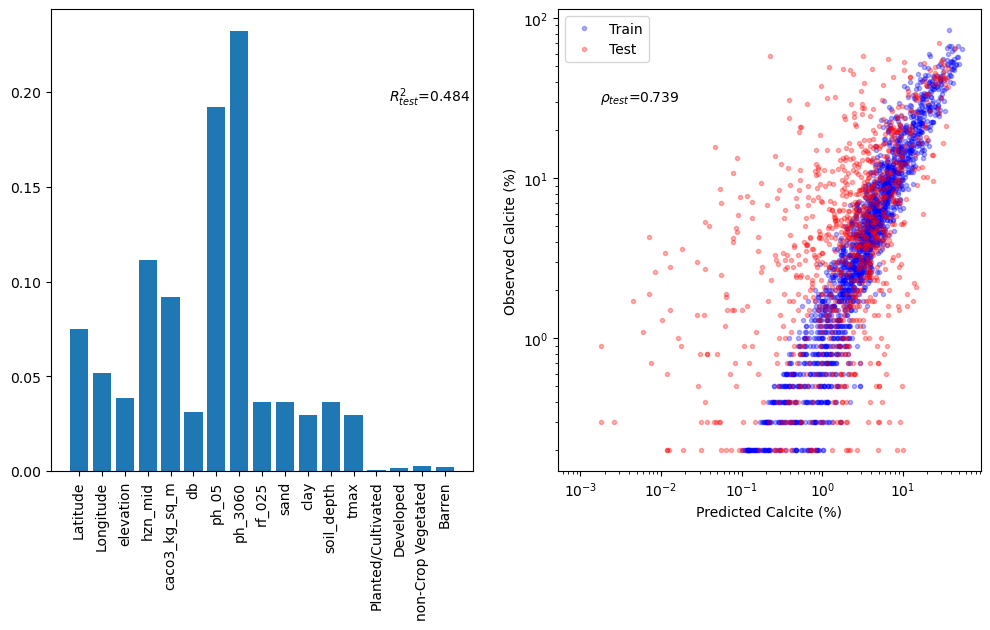

In [5]:
# Identify the column(s) that need one-hot encoding
y = alldata[varname]

if varname == 'Calcite':
    # LandCover is not very important but looks slightly better
    # the two ph layers are important
    # prcp & tmin don't help but tmax does
    categorical_features = ['LandCover1']
    numeric_features = ['Latitude','Longitude','elevation','hzn_mid',
                        'caco3_kg_sq_m', 'db', 'ph_05', 'ph_3060',
                        'rf_025', 'sand', 'clay', 'soil_depth', 'tmax']
else:
    categorical_features = ['LandCover1']
    # LandCover is important
    # 'sand' is not important at all; but clay is important and needs multi-layer
    # 'tmin' works better than 'tmax'
    # 'Latitude' & 'caco3_kg_sq_m' are not super important but keeping both looks the best
    numeric_features = ['Latitude', 'Longitude','elevation','hzn_mid', 'caco3_kg_sq_m', 
                        'db', 'ph', 'prcp', 'tmin', 'rf_025', 'clay_05', 'clay_3060', 'soil_depth']

X = alldata[numeric_features + categorical_features] 
if categorical_features:
    # aggregating those work best
    if varname == 'Kaolinit':
        X.loc[X['LandCover1'] == 'Shrubland', 'LandCover1'] = 'non-Crop Vegetated'
    X.loc[X['LandCover1'] == 'Forested Upland', 'LandCover1'] = 'non-Crop Vegetated'
    X.loc[X['LandCover1'] == 'Herbaceous Upland', 'LandCover1'] = 'non-Crop Vegetated'
    X.loc[X['LandCover1'] == 'Non-Natural Woody', 'LandCover1'] = 'non-Crop Vegetated'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create the predictors transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ])

# Create the y-transformer
# Create and fit the model with the preprocessor
model = TransformedTargetRegressor(
    RandomForestRegressor(random_state=42, n_estimators=100),
    func = np.log1p, inverse_func = np.expm1
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Performance metric
r2_test = pipeline.score(X_test, y_test)
rho_test, _ = pearsonr(y_test, y_pred_test)

# Plot the diagnostics
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
# Plot the importance
ax = axes.flat[0]
importance = pipeline.named_steps['regressor'].regressor_.feature_importances_
ax.bar(np.arange(len(importance)), importance)
ax.set_xticks(np.arange(len(importance)))
if categorical_features:
    ax.set_xticklabels(list(X.columns[:-1]) + list(X['LandCover1'].drop_duplicates())[1:], 
                       rotation = 90)
else:
    ax.set_xticklabels(X.columns, rotation = 90)
ax.text(0.8, 0.8, '$R^2_{test}$'+f'={r2_test:.3f}', transform = ax.transAxes)
# Plot the predicted value against observed value
ax = axes.flat[1]
ax.plot(y_pred_train, y_train, 'ob', markersize = 3, 
        alpha = 0.3, label = 'Train')
ax.plot(y_pred_test, y_test, 'or', markersize = 3, 
        alpha = 0.3, label = 'Test')
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(0.1, 0.8, r'$\rho$' + '$_{test}$' + f'={rho_test:.3f}', transform = ax.transAxes)
ax.legend()
ax.set_xlabel(f'Predicted {varname} (%)')
ax.set_ylabel(f'Observed {varname} (%)')

In [6]:
""" SVM is clearly worse than Random Forest 

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ])

# Create a pipeline that includes preprocessing and SVM
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf', C=100, epsilon=0.1))
])

# Fit the pipeline
svm_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = svm_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

plt.plot(y_pred_train, y_train, 'ob', markersize = 3, alpha = 0.3)
plt.plot(y_pred, y_test, 'or', markersize = 3, alpha = 0.3)
"""

' SVM is clearly worse than Random Forest \n\n# Define the preprocessing steps\npreprocessor = ColumnTransformer(\n    transformers=[\n        (\'num\', StandardScaler(), numeric_features),\n        (\'cat\', OneHotEncoder(drop=\'first\', sparse=False), categorical_features)\n    ])\n\n# Create a pipeline that includes preprocessing and SVM\nsvm_pipeline = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'regressor\', SVR(kernel=\'rbf\', C=100, epsilon=0.1))\n])\n\n# Fit the pipeline\nsvm_pipeline.fit(X_train, y_train)\n\n# Make predictions\ny_pred = svm_pipeline.predict(X_test)\n\n# Evaluate the model\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\n\nprint(f"Mean Squared Error: {mse}")\nprint(f"R2 Score: {r2}")\n\nplt.plot(y_pred_train, y_train, \'ob\', markersize = 3, alpha = 0.3)\nplt.plot(y_pred, y_test, \'or\', markersize = 3, alpha = 0.3)\n'

3. Create the predicted map

In [7]:
# Create reprojected map files
def reproject_raster(src_path, dst_path, dst_crs='EPSG:4326', resolution=0.5, 
                     resampling=Resampling.bilinear):
    with rio.open(src_path) as src:
        # Calculate the transform for the new CRS and resolution
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds, resolution = resolution
        )
        # Update the metadata for the output file
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        # Create the reprojected raster file
        with rio.open(dst_path, 'w', **kwargs) as dst:
            # Reproject and save each band
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=resampling
                )
    print(f"Reprojected raster saved to {dst_path}")

for file in ssurgo_file_list:
    src_path = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'SSURGO', f'{file}.tif')
    dst_path = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'SSURGO', 
                            f'reproj_{file}.tif')
    if recreate_reproj_files or not os.path.exists(dst_path):
        reproject_raster(src_path, dst_path, dst_crs='EPSG:4326', resolution = 0.1)

for file in ['USGS_3DEP_800m_EPSG5070', 'DAYMET_V4_Climatology_1980_2010']:
    src_path = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', f'{file}.tif')
    dst_path = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', f'reproj_{file}.tif')
    if recreate_reproj_files or not os.path.exists(dst_path):
        reproject_raster(src_path, dst_path, dst_crs='EPSG:4326', resolution = 0.1, 
                         resampling = Resampling.nearest)

for year in [2001, 2004, 2006, 2008]:
    src_path = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'NLCD', f'NLCD_{year}.tif')
    dst_path = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'NLCD', 
                            f'reproj_NLCD_{year}.tif')
    if recreate_reproj_files or not os.path.exists(dst_path):
        reproject_raster(src_path, dst_path, dst_crs='EPSG:4326', resolution = 0.1, 
                         resampling = Resampling.nearest)

Reprojected raster saved to /gpfs/wolf2/cades/cli185/scratch/ywo/ERW_LDRD/data/SSURGO/reproj_caco3_kg_sq_m.tif
Reprojected raster saved to /gpfs/wolf2/cades/cli185/scratch/ywo/ERW_LDRD/data/SSURGO/reproj_db.tif
Reprojected raster saved to /gpfs/wolf2/cades/cli185/scratch/ywo/ERW_LDRD/data/SSURGO/reproj_soil_depth.tif
Reprojected raster saved to /gpfs/wolf2/cades/cli185/scratch/ywo/ERW_LDRD/data/SSURGO/reproj_rf_025.tif
Reprojected raster saved to /gpfs/wolf2/cades/cli185/scratch/ywo/ERW_LDRD/data/SSURGO/reproj_ph.tif
Reprojected raster saved to /gpfs/wolf2/cades/cli185/scratch/ywo/ERW_LDRD/data/SSURGO/reproj_ph_05.tif
Reprojected raster saved to /gpfs/wolf2/cades/cli185/scratch/ywo/ERW_LDRD/data/SSURGO/reproj_ph_025.tif
Reprojected raster saved to /gpfs/wolf2/cades/cli185/scratch/ywo/ERW_LDRD/data/SSURGO/reproj_ph_3060.tif
Reprojected raster saved to /gpfs/wolf2/cades/cli185/scratch/ywo/ERW_LDRD/data/SSURGO/reproj_sand.tif
Reprojected raster saved to /gpfs/wolf2/cades/cli185/scratch/yw

In [8]:
collect_data = {}

In [9]:
# Determine the overlapping boundary of the reprojected file series
h1 = rio.open(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'SSURGO', 
                           'reproj_caco3_kg_sq_m.tif'))
h2 = rio.open(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                           'reproj_USGS_3DEP_800m_EPSG5070.tif'))
h3 = rio.open(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                           'reproj_DAYMET_V4_Climatology_1980_2010.tif'))
h4 = rio.open(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'NLCD',
                           'reproj_NLCD_2001.tif'))

bounds1 = h1.bounds
bounds2 = h2.bounds
bounds3 = h3.bounds
bounds4 = h4.bounds

# Calculate the overlapping bounds
overlap_bounds = (
    max(bounds1.left, bounds2.left, bounds3.left, bounds4.left),
    max(bounds1.bottom, bounds2.bottom, bounds3.bottom, bounds4.bottom),
    min(bounds1.right, bounds2.right, bounds3.right, bounds4.right),
    min(bounds1.top, bounds2.top, bounds3.top, bounds4.top)
)

h1.close()
h2.close()
h3.close()
h4.close()

# 
def read_limited_raster(file_path, band, bounds):
    h = rio.open(file_path)
    window = from_bounds(*bounds, h.transform)
    data = h.read(band, window = window, masked=True)
    data = np.where(data.mask, np.nan, data.data)
    h.close()
    return data

data = read_limited_raster(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'SSURGO', 
                                        'reproj_caco3_kg_sq_m.tif'), 1, overlap_bounds)
height = data.shape[0]
width = data.shape[1]

In [10]:
# Get the CONUS lat & lon from the reprojected geotiff files
h = rio.open(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'SSURGO',
                          'reproj_caco3_kg_sq_m.tif'))

# Create arrays to store the coordinates
lons = np.zeros((height, width))
lats = np.zeros((height, width))

# Get the raster's transform
transform = h.transform

# Iterate through all pixels
for row in range(height):
    for col in range(width):
        # Get the x,y coordinates of the current pixel
        x, y = rio.transform.xy(transform, row, col)

        # Reprojected files are already EPSG:4326
        # transformer = Transformer.from_crs(CRS.from_epsg(5070), CRS.from_epsg(4326), always_xy=True)
        # lon, lat = transformer.transform(x, y)

        # Store the coordinates
        lons[row, col] = x
        lats[row, col] = y
h.close()

collect_data['Latitude'] = lats
collect_data['Longitude'] = lons

In [11]:
# Cut the elevation data to the same extent of the CEC files
collect_data['elevation'] = read_limited_raster( \
    os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',
                 'reproj_USGS_3DEP_800m_EPSG5070.tif'), 1, overlap_bounds)

In [12]:
# Daymet meteorological variables - cut to SSURGO extent
collect_data['prcp'] = read_limited_raster( \
    os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',
                 'reproj_DAYMET_V4_Climatology_1980_2010.tif'), 1, overlap_bounds)
collect_data['tmax'] = read_limited_raster( \
    os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',
                 'reproj_DAYMET_V4_Climatology_1980_2010.tif'), 2, overlap_bounds)
collect_data['tmin'] = read_limited_raster( \
    os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',
                 'reproj_DAYMET_V4_Climatology_1980_2010.tif'), 3, overlap_bounds)

In [13]:
# Land cover - considering the mineral excel report is completed in 2013
# use pre-2010 land cover. Old data is okay because we want this map to
# represent background conditions. 
# The land cover in the mineral report is NLCD 1992; See HTML file
# Average NLCD 2001, 2004, 2006, 2008
luc_list = ['Mask_Out', 'Developed', 'Barren', 'Forested Upland', 'Herbaceous Upland',
            'Shrubland', 'Planted/Cultivated']
pct_luc = np.full([7, height, width], np.nan)
for j, name in enumerate(luc_list): 
    temp = np.full([4, height, width], np.nan)
    for i, year in enumerate([2001, 2004, 2006, 2008]):
        path_luc = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                                'NLCD', f'reproj_NLCD_{year}.tif')
        temp[i, :, :] = read_limited_raster(path_luc, j+1, overlap_bounds)
        h.close()
    pct_luc[j, :, :] = np.nanmean(temp, axis = 0)
# Replace Mask_Out by a small number so that it is only 
# selected if all other LUCs don't exist
pct_luc[0, :, :] = np.minimum(pct_luc[0, :, :], 1e-3)
# Find the dominant land cover type in each grid
collect_data['LandCover1'] = np.argmax(pct_luc, axis = 0)

/tmp/ipykernel_3033934/1918936449.py:16: RuntimeWarning: Mean of empty slice
  pct_luc[j, :, :] = np.nanmean(temp, axis = 0)


In [14]:
# SSURGO maps
for file in ssurgo_file_list:
    collect_data[file] = read_limited_raster(os.path.join(os.environ['PROJDIR'], 
        'ERW_LDRD', 'data', 'SSURGO', f'reproj_{file}.tif'), 1, overlap_bounds)

In [15]:
# re-form into pandas data frame
for key in collect_data.keys():
    collect_data[key] = collect_data[key].reshape(-1)
collect_data = pd.DataFrame(collect_data)

# re-map land cover into string
collect_data['LandCover1'] = collect_data['LandCover1'].map({0: 'Mask_out', 1: 'Developed', 
                            2: 'Barren', 3: 'Forested Upland', 
                            4: 'Herbaceous Upland', 5: 'Shrubland', 
                            6: 'Planted/Cultivated'})

# subset to only valid points for prediction
invalid_locations = (collect_data.isna().sum(axis = 1) > 0) | \
    (collect_data['LandCover1'] == 'Mask_out')
collect_data_valid = collect_data.loc[~invalid_locations, :]

In [16]:
# Loop through multiple soil layers to predict the soil map
predicted_map = np.full([len(elm_nodes), height, width], np.nan)

for i, hzn_mid in enumerate(elm_nodes):
    # Insert the horizon depth into the predictor
    collect_data_valid.loc[:, 'hzn_mid'] = hzn_mid
    # Re-format depending on which variable
    X = collect_data_valid.loc[:, numeric_features + categorical_features]
    if categorical_features:
        # aggregating those work best
        if varname == 'Kaolinit':
            X.loc[X['LandCover1'] == 'Shrubland', 'LandCover1'] = 'non-Crop Vegetated'
        X.loc[X['LandCover1'] == 'Forested Upland', 'LandCover1'] = 'non-Crop Vegetated'
        X.loc[X['LandCover1'] == 'Herbaceous Upland', 'LandCover1'] = 'non-Crop Vegetated'
        X.loc[X['LandCover1'] == 'Non-Natural Woody', 'LandCover1'] = 'non-Crop Vegetated'
    y_pred = pipeline.predict(X)
    temp = np.full(len(invalid_locations), np.nan)
    temp[~invalid_locations] = y_pred

    predicted_map[i, :, :] = temp.reshape([height, width])

/tmp/ipykernel_3033934/2794240607.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collect_data_valid.loc[:, 'hzn_mid'] = hzn_mid


4. Save the predicted map to geotiff

In [17]:
# Grab the projection info
h = rio.open(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'SSURGO', 
                          'reproj_caco3_kg_sq_m.tif'))
kwargs = h.meta.copy()
kwargs['count'] = predicted_map.shape[0]

with rio.open(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', f'RF_{varname}.tif'), 
              'w', **kwargs) as dst:
    for i in range(predicted_map.shape[0]):
        dst.write(predicted_map[i], i + 1) # Band indexing in rasterio starts at 1
h.close()

5. Visualize the predicted maps

Still need to fix the holes in QGIS - Processing Toolbox - GRASS - Raster - r.fill.stats

Make sure to check "preserve original cell values" to prevent original values from being smoothed

See `interp_soilMineral_RF_QGIS.py` for the python code to run in QGIS console

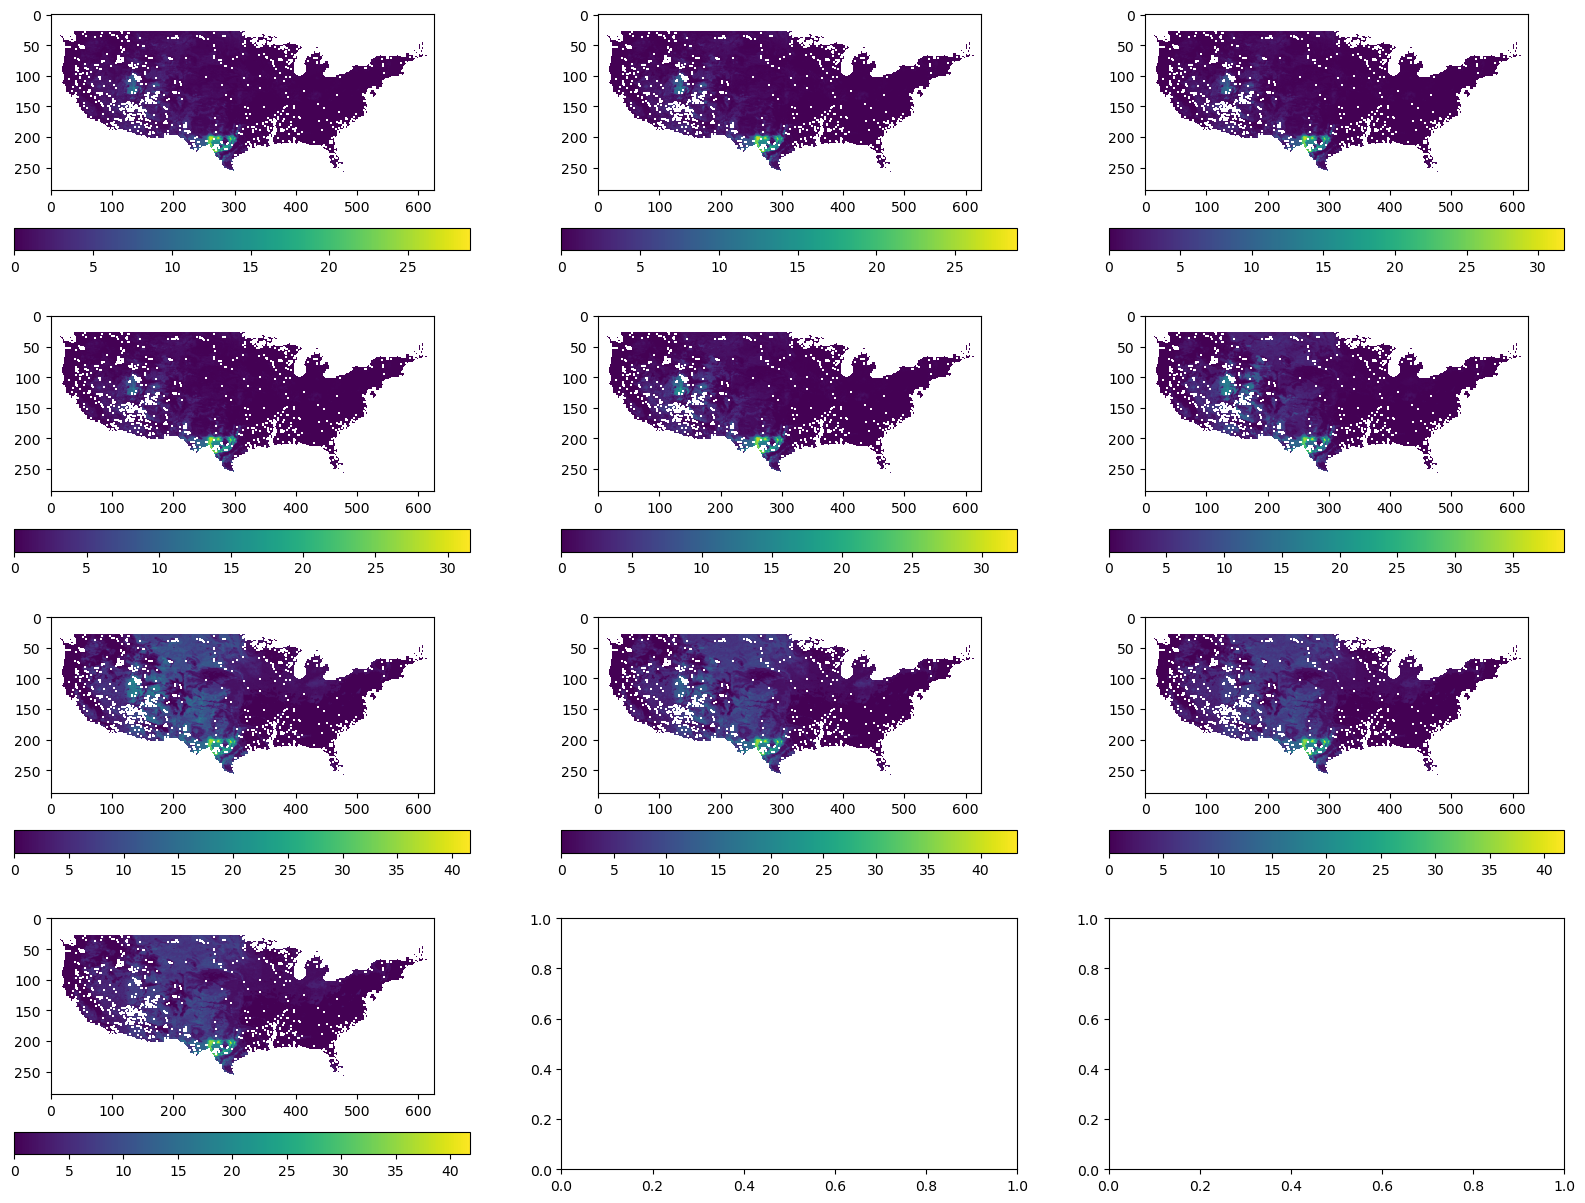

In [18]:
h = rio.open(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', f'RF_{varname}.tif'))

fig, axes = plt.subplots(4, 3, figsize = (20, 15))
for i in range(h.count):
    ax = axes.flat[i]
    cf = ax.imshow(h.read(i+1))
    plt.colorbar(cf, ax = ax, orientation = 'horizontal')

h.close()

6. Interpolate to 0.5 degrees with more gap-filling

See double checking in QGIS

In [3]:
h = rio.open(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', f'RF_{varname}_filled.tif'))

# tif file is in EPSG:5070
left, bottom, right, top = h.bounds
rows, cols = np.indices(h.shape)
src_x, src_y = rio.transform.xy(h.transform, rows, cols)
lons = np.array(src_x)
lats = np.array(src_y)

# conduct reprojection
lats_target = np.arange(23.25, 54.26, 0.5)
lons_target = np.arange(234.75, 293.26, 0.5) - 360.
lons_mesh, lats_mesh = np.meshgrid(lons_target, lats_target)
src_coords = np.array([lons.flatten(), lats.flatten()]).T

# read data
ds = np.full([10, len(lats_target), len(lons_target)], np.nan)
for band in range(1, 11):
    data = h.read(band, masked = True)
    src_data_flat = data.flatten()

    data_reproj = griddata(src_coords, src_data_flat, (lons_mesh, lats_mesh),
                           method='linear')
    # use the nearest neighbor for the NE patch of missing data
    search_rows, search_cols = np.where(~np.isnan(data_reproj))
    for row, col in it.product(range(45, 49), range(110, 114)):
        if (row == 48) and (col == 110 or col == 111):
            continue
        if (row == 47) and col == 110:
            continue
        if np.isnan(data_reproj[row,col]):
            ind = np.argmin(np.power(search_rows-row,2) + np.power(search_cols-col,2))
            find_row, find_col = search_rows[ind], search_cols[ind]
            data_reproj[row,col] = data_reproj[find_row, find_col]
    # data_reproj[45, 109] = data_reproj[45, 110]
    ds[band-1, :, :] = data_reproj

h.close()

# save to netcdf
ds = xr.DataArray(ds, coords = {'lat': lats_target, 'lon': lons_target}, 
                    dims = ['nlevsoi','lat','lon'])
filename = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 
                        f'RF_{varname}_filled_interp.nc')
os.remove(filename)
ds.to_dataset(name = f'PCT_{varname}').to_netcdf(filename)